# Inception

In [1]:
import os

HUGGINGFACE_TOKEN = "HF_TOKEN"
os.environ['HF_TOKEN'] = HUGGINGFACE_TOKEN
os.environ['HUGGINGFACEHUB_API_TOKEN'] = HUGGINGFACE_TOKEN

In [2]:
from huggingface_hub import login

login(token=HUGGINGFACE_TOKEN)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!nvidia-smi

Thu Jan 30 03:30:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!python -V

Python 3.11.11


In [6]:
# !pip install -U datasets
!pip install evaluate
!pip install py7zr

!pip install sacrebleu
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatib

In [7]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.11
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
ale-py                             0.10.1
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.6.0
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2025.1.27.0.32.44
astunparse                         1.6.3
atpublic                           4.1.0
attrs                              25.1.0
audioread         

In [8]:
!cp -R "/content/drive/MyDrive/data" .

# Import

In [3]:
import os
import os.path as osp
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from datasets import Dataset, DatasetDict

import time
from tqdm import tqdm

from datasets import load_dataset

In [4]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

# nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
# Import the metrics
import evaluate

bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
import torch
from transformers import pipeline, DataCollatorForSeq2Seq
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
from transformers import TrainingArguments, Trainer, Seq2SeqTrainingArguments

from transformers import set_seed

In [7]:
seed_value = 5

set_seed(seed_value)
np.random.seed(seed_value)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load pre-trained model

In [9]:
model_name = "google/gemma-2-2b-it"

gemma = pipeline(
    "text-generation",
    model=model_name,
    torch_dtype=torch.float16,
    device_map="auto",)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [12]:
gemma.device

device(type='cuda', index=0)

# Dataset

In [14]:
# function to read the dataset json file
def read_jsonl(path):
    data = []

    with open(path, 'r', encoding='utf-8') as fd:
        for line in fd:
            line_data = json.loads(line)
            data.append(line_data)

    return data


# create Dataset object from dataframe
def read_dataset(dataset_path):
    data = read_jsonl(dataset_path)
    df = pd.DataFrame(data)
    return df


# function to combine trainm test, val data in the same object
def create_combined_dataset(train_data_path,
                            val_data_path,
                            test_data_path):

    train_dataset = read_dataset(train_data_path)
    val_dataset = read_dataset(val_data_path)
    test_dataset = read_dataset(test_data_path)

    dataset = DatasetDict({
        "train": Dataset.from_pandas(train_dataset),
        "validation": Dataset.from_pandas(val_dataset),
        "test": Dataset.from_pandas(test_dataset),
    })

    return dataset


In [15]:
data_fol ="/content/data"
train_path = osp.join(data_fol, "train.jsonl")
val_path = osp.join(data_fol, "validate.jsonl")
test_path = osp.join(data_fol, "test.jsonl")

dataset_original = create_combined_dataset(train_path, val_path, test_path)
dataset_original

DatasetDict({
    train: Dataset({
        features: ['idx', 'inputs', 'target'],
        num_rows: 2735
    })
    validation: Dataset({
        features: ['idx', 'inputs', 'target'],
        num_rows: 341
    })
    test: Dataset({
        features: ['idx', 'inputs', 'target'],
        num_rows: 343
    })
})

In [16]:
val_dataset = dataset_original["validation"]
test_dataset = dataset_original["test"]

# Prompt Engineering

### Prompt templates & code

In [20]:
# zero_short_prompt_messages = [
#     {"role": "user",
#      "content": "Do the text summarization of the following text:\n\n{}" },
# ]

zero_shot_base_prompt_messages = []

# ********************************************************************

one_shot_example = {
    "text":"Patchy airspace disease is noted within the right middle lobe. Subtle opacities are present within the lingula as well. There is no pneumothorax or pleural effusion. The heart size is normal.",
    "summary": "Patchy right middle lobe and lingular airspace disease compatible with multilobar pneumonia."
}

one_shot_base_prompt_messages = [
    {"role": "user",
     "content": "Task is summarization; Here is one example:\n\n{}".format(one_shot_example["text"]) },
    {"role": "assistant",
    "content": one_shot_example["summary"]},
]

# ********************************************************************

two_shot_example = {
    "text": [ "Patchy airspace disease is noted within the right middle lobe. Subtle opacities are present within the lingula as well. There is no pneumothorax or pleural effusion. The heart size is normal.",
             "Heart size and pulmonary vascularity appears normal limits. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. Callus or granulomas identified. Left XXXX-A-XXXX remains in XXXX."
    ],
    "summary": [ "Patchy right middle lobe and lingular airspace disease compatible with multilobar pneumonia.",
                "No evidence of active disease."
    ]
}

two_shot_base_prompt_messages = [
    {"role": "user",
     "content": "Task is summarization; Here are some examples:\n\n{}".format(two_shot_example["text"][0]) },
    {"role": "assistant",
    "content": two_shot_example["summary"][0] },
    {"role": "user",
     "content": two_shot_example["text"][1] },
    {"role": "assistant",
    "content": two_shot_example["summary"][1] },
]

# ********************************************************************

four_shot_example = {
    "text": [ "Patchy airspace disease is noted within the right middle lobe. Subtle opacities are present within the lingula as well. There is no pneumothorax or pleural effusion. The heart size is normal.",
             "Heart size and pulmonary vascularity appears normal limits. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. Callus or granulomas identified. Left XXXX-A-XXXX remains in XXXX.",
              "Stable cardiomegaly. Thoracic aortic atherosclerotic calcifications are noted. There is a prominence of the pulmonary vasculature. No consolidating airspace disease is seen. No pleural effusion or pneumothorax.",
              "Normal heart size and mediastinal contour. Right lung base airspace disease on frontal XXXX. XXXX opacities in the left lung base consistent with atelectasis. No pneumothorax. No pleural effusion. Mild wedge XXXX deformity of T12."

    ],
    "summary": [ "Patchy right middle lobe and lingular airspace disease compatible with multilobar pneumonia.",
                "No evidence of active disease.",
                 "Cardiomegaly and pulmonary vascular congestion.",
                 "Right lung base airspace disease and left base atelectasis."
    ]
}

four_shot_base_prompt_messages = [
    {"role": "user",
     "content": "Task is summarization; Here are some examples:\n\n{}".format(four_shot_example["text"][0]) },
    {"role": "assistant",
    "content": four_shot_example["summary"][0] },
    {"role": "user",
     "content": four_shot_example["text"][1] },
    {"role": "assistant",
    "content": four_shot_example["summary"][1] },
    {"role": "user",
     "content": four_shot_example["text"][2] },
    {"role": "assistant",
    "content": four_shot_example["summary"][2] },
    {"role": "user",
     "content": four_shot_example["text"][3] },
    {"role": "assistant",
    "content": four_shot_example["summary"][3] },
]


In [21]:
def generate_prompt(text, model_pipeline, prompt_message_base):

    if len(prompt_message_base)==0: # zero shot
        prompt_messages = [
            {"role": "user",
            "content": "Do the text summarization of the following text:\n\n{}".format(text) },
        ]
    else:
        prompt_messages = prompt_message_base + [ {"role":"user", "content":text} ]

    prompt = model_pipeline.tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True)

    return prompt


def generate_summary_from_prompt(prompt, model_pipeline, temperature=0.1, top_k=20, top_p=0.3):

    out_summary = model_pipeline(
        prompt,
        add_special_tokens=True,
        do_sample=True,
        temperature=temperature, top_k=top_k, top_p=top_p,
        pad_token_id=model_pipeline.tokenizer.eos_token_id)

    summary = out_summary[0]["generated_text"][len(prompt):]

    return summary


In [22]:
def generate_summary(model_pipeline, dataset, column_text, column_target,
                     prompt_message_base,
                     temperature=0.1, top_k=20, top_p=0.3):

    text_col = dataset[column_text]
    text_ref = dataset[column_target]

    N = len(text_col)
    summary_gen_ll = []
    for i in tqdm(range(N)):
        text = text_col[i]
        prompt = generate_prompt(text, model_pipeline, prompt_message_base)
        summary_gen = generate_summary_from_prompt(prompt, model_pipeline, temperature=temperature, top_k=top_k, top_p=top_p)
        summary_gen_ll.append(summary_gen)

    df = pd.DataFrame({"text":text_col, "reference":text_ref, "summary_gen":summary_gen_ll})

    return df


In [23]:
def evaluate_dataset(predicted_dataset,
                     metric):
    # INPUT:
        # predicted_dataset: dataframe with generated summaries
        # metric: the metric to compute

    N = len(predicted_dataset)

    for i in tqdm(range(0, N)):
        ref = predicted_dataset["reference"][i]
        summ_gen = predicted_dataset["summary_gen"][i]
        summ_gen = summ_gen.replace("<n>", " ")

        metric.add_batch(predictions=[summ_gen], references=[ref])

    score = metric.compute()
    return score


### Zero shot

In [26]:
prompt_base = zero_shot_base_prompt_messages
zero_shot_summ_df = generate_summary(gemma, test_dataset, "inputs", "target", prompt_base, )

100%|██████████| 343/343 [07:37<00:00,  1.33s/it]


In [27]:
zero_shot_summ_df.to_csv("zero_shot_results.csv", index=False)

In [28]:
scores = evaluate_dataset(zero_shot_summ_df, rouge_metric)
pd.DataFrame.from_dict(scores, orient="index")

100%|██████████| 343/343 [00:00<00:00, 2775.70it/s]


,0
rouge1,0.098216
rouge2,0.015448
rougeL,0.088969
rougeLsum,0.089141


In [29]:
zero_shot_summ_df.head()

,text,reference,summary_gen
0,Heart size within normal limits. No focal alve...,No acute cardiopulmonary findings,The chest X-ray shows a normal heart size. The...
1,Mediastinal contours are normal. Opacity withi...,Opacification of the right middle and lower lo...,The chest X-ray shows normal mediastinal conto...
2,"No gross consolidation, atelectasis or infiltr...",1. Negative for acute cardiopulmonary findings.,The chest X-ray shows no signs of:\n\n* **Cons...
3,There is no focal airspace consolidation or pl...,No acute cardiopulmonary abnormality. .,The patient has no signs of focal airspace con...
4,Heart size and mediastinal contour within norm...,No acute cardiopulmonary abnormality.,The chest X-ray shows no abnormalities. The he...


In [30]:
# get the difference in the no of words in original text and the generated summary
word_length_diff_ll = zero_shot_summ_df.apply(lambda row: len(word_tokenize(row["text"]))-len(word_tokenize(row["summary_gen"])),
                                              axis=1 )

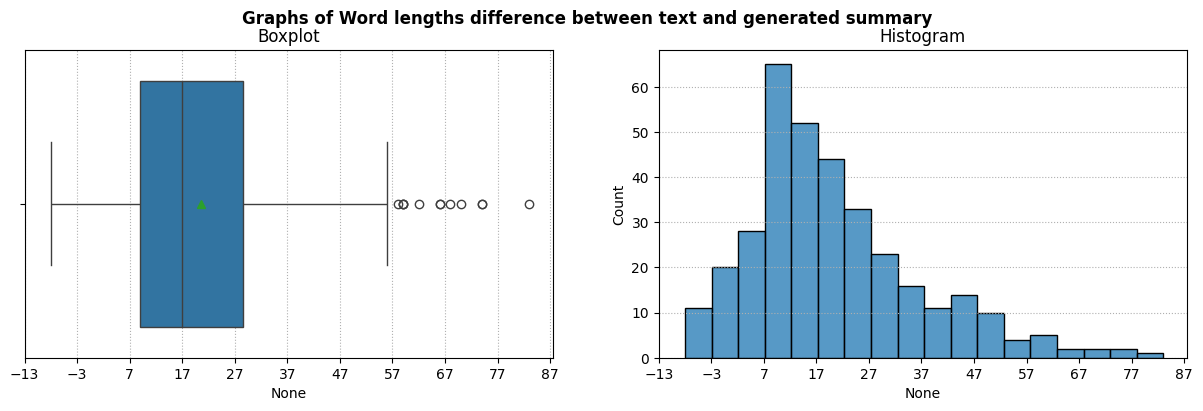

In [31]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle("Graphs of Word lengths difference between text and generated summary", fontweight="bold")

sns.boxplot(x=word_length_diff_ll, showmeans=True, ax=ax[0])
ax[0].grid(axis="x", linestyle="dotted", linewidth=0.8, alpha=1)
ax[0].set_xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
ax[0].set_title("Boxplot")

sns.histplot(x=word_length_diff_ll, binwidth=5, ax=ax[1])
ax[1].grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
ax[1].set_xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
ax[1].set_title("Histogram")

plt.show()

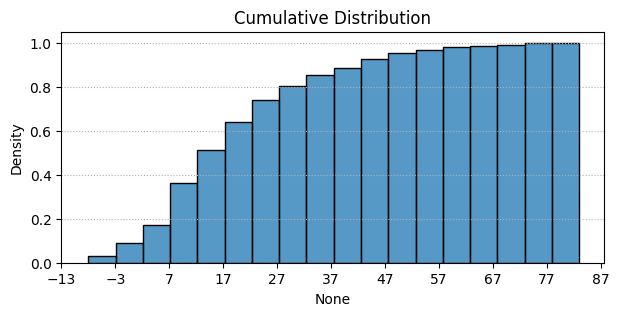

In [32]:
plt.figure(figsize=(7, 3))
plt.title("Cumulative Distribution")
sns.histplot(x=word_length_diff_ll, binwidth=5, kde=False, cumulative=True, stat="density")
plt.grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
plt.xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
plt.show()

In [33]:
n1 = np.sum( np.array(word_length_diff_ll) <=0 )
n2 = len(word_length_diff_ll)
print("Total generated summaries with length greater than text: ", n1)
print("Total summaries: ", n2)
print("Ratio: ", n1/n2)

Total generated summaries with length greater than text:  22
Total summaries:  343
Ratio:  0.0641399416909621


In [34]:
# display some of the generated summaries

total = 5

np.random.seed(5)
choice_list = np.random.choice(len(zero_shot_summ_df), total, replace=False)

for i in choice_list:
    text = zero_shot_summ_df.iloc[i]["text"]
    ref = zero_shot_summ_df.iloc[i]["reference"]
    summ_gen = zero_shot_summ_df.iloc[i]["summary_gen"]

    print("TEXT: ", text)
    print("REFERENCE: ", ref)
    print("SUMMARY GEN: ", summ_gen)
    print("\n")

TEXT:  The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided airspace disease.
REFERENCE:  No acute cardiopulmonary disease.
SUMMARY GEN:  The chest X-ray shows no signs of pneumonia, pleural effusion, or pneumothorax. A left


TEXT:  Lordotic projection and large body habitus. Limited mediastinal evaluation. Severe cardiomegaly. No visualized pneumothorax. No large effusion or airspace disease. No fracture.
REFERENCE:  Severe cardiomegaly. Limited mediastinal evaluation given body habitus and lordotic projection. Recommend XXXX for further evaluation of mediastinum given T/Spine injury noted on C/Spine imaging. Critical result notification documented through Primordial.
SUMMARY GEN:  The patient has a large body habitus and a lordotic projection.  There is evidence of severe



### One Shot

In [35]:
prompt_base = one_shot_base_prompt_messages
one_shot_summ_df = generate_summary(gemma, test_dataset, "inputs", "target", prompt_base, )

100%|██████████| 343/343 [07:12<00:00,  1.26s/it]


In [36]:
one_shot_summ_df.to_csv("one_shot_results.csv", index=False)

In [37]:
scores = evaluate_dataset(one_shot_summ_df, rouge_metric)
pd.DataFrame.from_dict(scores, orient="index")

100%|██████████| 343/343 [00:00<00:00, 1966.63it/s]


,0
rouge1,0.131733
rouge2,0.031757
rougeL,0.118188
rougeLsum,0.118113


In [38]:
one_shot_summ_df.head()

,text,reference,summary_gen
0,Heart size within normal limits. No focal alve...,No acute cardiopulmonary findings,The lungs show patchy airspace disease in the ...
1,Mediastinal contours are normal. Opacity withi...,Opacification of the right middle and lower lo...,Right middle and lower lobe opacities with no ...
2,"No gross consolidation, atelectasis or infiltr...",1. Negative for acute cardiopulmonary findings.,The report indicates patchy airspace disease i...
3,There is no focal airspace consolidation or pl...,No acute cardiopulmonary abnormality. .,The report describes patchy airspace disease i...
4,Heart size and mediastinal contour within norm...,No acute cardiopulmonary abnormality.,The report describes patchy airspace disease i...


In [39]:
# get the difference in the no of words in original text and the generated summary
word_length_diff_ll = one_shot_summ_df.apply(lambda row: len(word_tokenize(row["text"]))-len(word_tokenize(row["summary_gen"])),
                                              axis=1 )

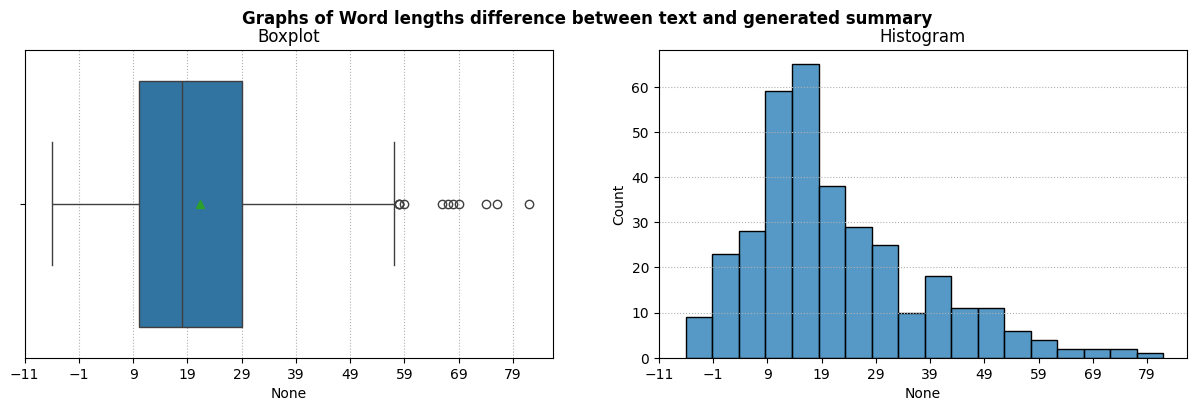

In [40]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle("Graphs of Word lengths difference between text and generated summary", fontweight="bold")

sns.boxplot(x=word_length_diff_ll, showmeans=True, ax=ax[0])
ax[0].grid(axis="x", linestyle="dotted", linewidth=0.8, alpha=1)
ax[0].set_xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
ax[0].set_title("Boxplot")

sns.histplot(x=word_length_diff_ll, binwidth=5, ax=ax[1])
ax[1].grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
ax[1].set_xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
ax[1].set_title("Histogram")

plt.show()

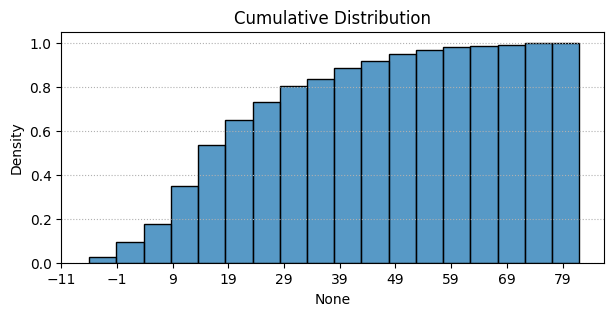

In [41]:
plt.figure(figsize=(7, 3))
plt.title("Cumulative Distribution")
sns.histplot(x=word_length_diff_ll, binwidth=5, kde=False, cumulative=True, stat="density")
plt.grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
plt.xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
plt.show()

In [42]:
n1 = np.sum( np.array(word_length_diff_ll) <=0 )
n2 = len(word_length_diff_ll)
print("Total generated summaries with length greater than text: ", n1)
print("Total summaries: ", n2)
print("Ratio: ", n1/n2)

Total generated summaries with length greater than text:  22
Total summaries:  343
Ratio:  0.0641399416909621


In [43]:
# display some of the generated summaries

total = 5

np.random.seed(5)
choice_list = np.random.choice(len(one_shot_summ_df), total, replace=False)

for i in choice_list:
    text = one_shot_summ_df.iloc[i]["text"]
    ref = one_shot_summ_df.iloc[i]["reference"]
    summ_gen = one_shot_summ_df.iloc[i]["summary_gen"]

    print("TEXT: ", text)
    print("REFERENCE: ", ref)
    print("SUMMARY GEN: ", summ_gen)
    print("\n")

TEXT:  The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided airspace disease.
REFERENCE:  No acute cardiopulmonary disease.
SUMMARY GEN:  Left lung calcified granuloma present, with resolution of left-sided airspace disease.  Heart,


TEXT:  Lordotic projection and large body habitus. Limited mediastinal evaluation. Severe cardiomegaly. No visualized pneumothorax. No large effusion or airspace disease. No fracture.
REFERENCE:  Severe cardiomegaly. Limited mediastinal evaluation given body habitus and lordotic projection. Recommend XXXX for further evaluation of mediastinum given T/Spine injury noted on C/Spine imaging. Critical result notification documented through Primordial.
SUMMARY GEN:  The chest x-ray shows severe cardiomegaly with a large body habitus and lordotic proje

### Two shot

In [44]:
prompt_base = two_shot_base_prompt_messages
two_shot_summ_df = generate_summary(gemma, test_dataset, "inputs", "target", prompt_base, )

100%|██████████| 343/343 [06:52<00:00,  1.20s/it]


In [45]:
two_shot_summ_df.to_csv("two_shot_results.csv", index=False)

In [46]:
scores = evaluate_dataset(two_shot_summ_df, rouge_metric)
pd.DataFrame.from_dict(scores, orient="index")

100%|██████████| 343/343 [00:00<00:00, 3561.88it/s]


,0
rouge1,0.132146
rouge2,0.032003
rougeL,0.116865
rougeLsum,0.117514


In [47]:
two_shot_summ_df.head()

,text,reference,summary_gen
0,Heart size within normal limits. No focal alve...,No acute cardiopulmonary findings,"Possible history of granulomatous process, wit..."
1,Mediastinal contours are normal. Opacity withi...,Opacification of the right middle and lower lo...,"Right middle and lower lobe opacities, no pneu..."
2,"No gross consolidation, atelectasis or infiltr...",1. Negative for acute cardiopulmonary findings.,"Normal lung parenchyma, no signs of consolidat..."
3,There is no focal airspace consolidation or pl...,No acute cardiopulmonary abnormality. .,Normal heart size and no pneumothorax. No foc...
4,Heart size and mediastinal contour within norm...,No acute cardiopulmonary abnormality.,Normal heart size and mediastinum. No evidence...


In [48]:
# get the difference in the no of words in original text and the generated summary
word_length_diff_ll = two_shot_summ_df.apply(lambda row: len(word_tokenize(row["text"]))-len(word_tokenize(row["summary_gen"])),
                                              axis=1 )

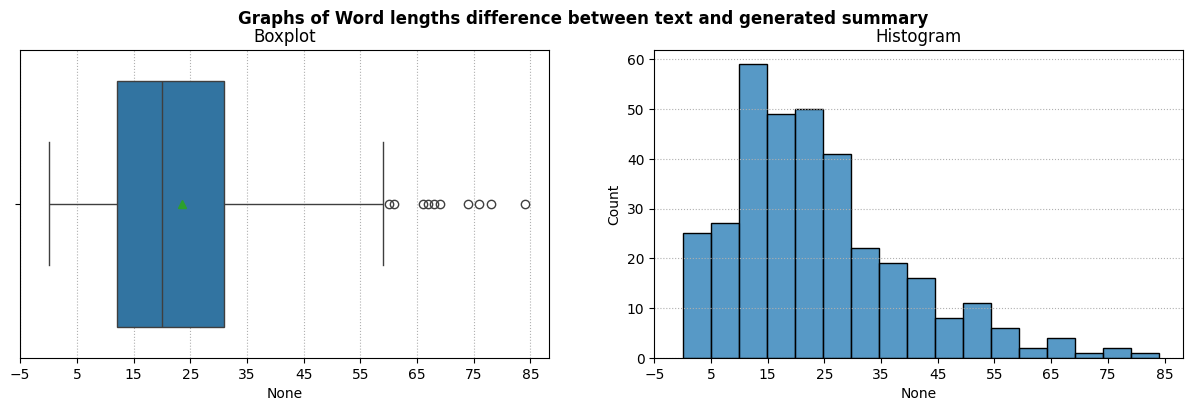

In [49]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle("Graphs of Word lengths difference between text and generated summary", fontweight="bold")

sns.boxplot(x=word_length_diff_ll, showmeans=True, ax=ax[0])
ax[0].grid(axis="x", linestyle="dotted", linewidth=0.8, alpha=1)
ax[0].set_xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
ax[0].set_title("Boxplot")

sns.histplot(x=word_length_diff_ll, binwidth=5, ax=ax[1])
ax[1].grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
ax[1].set_xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
ax[1].set_title("Histogram")

plt.show()

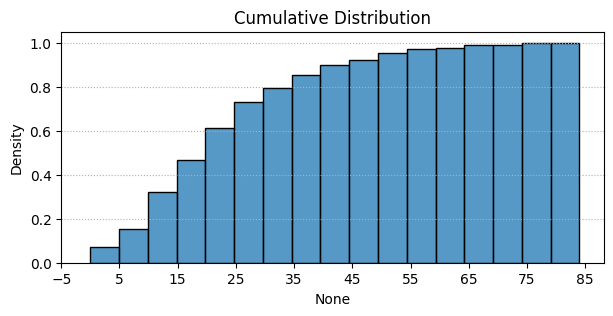

In [50]:
plt.figure(figsize=(7, 3))
plt.title("Cumulative Distribution")
sns.histplot(x=word_length_diff_ll, binwidth=5, kde=False, cumulative=True, stat="density")
plt.grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
plt.xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
plt.show()

In [51]:
n1 = np.sum( np.array(word_length_diff_ll) <=0 )
n2 = len(word_length_diff_ll)
print("Total generated summaries with length greater than text: ", n1)
print("Total summaries: ", n2)
print("Ratio: ", n1/n2)

Total generated summaries with length greater than text:  2
Total summaries:  343
Ratio:  0.0058309037900874635


In [52]:
# display some of the generated summaries

total = 5

np.random.seed(5)
choice_list = np.random.choice(len(two_shot_summ_df), total, replace=False)

for i in choice_list:
    text = two_shot_summ_df.iloc[i]["text"]
    ref = two_shot_summ_df.iloc[i]["reference"]
    summ_gen = two_shot_summ_df.iloc[i]["summary_gen"]

    print("TEXT: ", text)
    print("REFERENCE: ", ref)
    print("SUMMARY GEN: ", summ_gen)
    print("\n")

TEXT:  The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided airspace disease.
REFERENCE:  No acute cardiopulmonary disease.
SUMMARY GEN:  Left lung calcified granuloma present, with resolution of left-sided airspace disease. 



TEXT:  Lordotic projection and large body habitus. Limited mediastinal evaluation. Severe cardiomegaly. No visualized pneumothorax. No large effusion or airspace disease. No fracture.
REFERENCE:  Severe cardiomegaly. Limited mediastinal evaluation given body habitus and lordotic projection. Recommend XXXX for further evaluation of mediastinum given T/Spine injury noted on C/Spine imaging. Critical result notification documented through Primordial.
SUMMARY GEN:  Severe cardiomegaly with lordotic projection and large body habitus. No pneumothorax, effusi

### Four shot

In [53]:
prompt_base = four_shot_base_prompt_messages
four_shot_summ_df = generate_summary(gemma, test_dataset, "inputs", "target", prompt_base, )

100%|██████████| 343/343 [06:05<00:00,  1.07s/it]


In [54]:
four_shot_summ_df.to_csv("four_shot_results.csv", index=False)

In [55]:
scores = evaluate_dataset(four_shot_summ_df, rouge_metric)
pd.DataFrame.from_dict(scores, orient="index")

100%|██████████| 343/343 [00:00<00:00, 3595.58it/s]


,0
rouge1,0.133998
rouge2,0.044665
rougeL,0.121892
rougeLsum,0.122570


In [56]:
four_shot_summ_df.head()

,text,reference,summary_gen
0,Heart size within normal limits. No focal alve...,No acute cardiopulmonary findings,"Possible history of granulomatous process, wit..."
1,Mediastinal contours are normal. Opacity withi...,Opacification of the right middle and lower lo...,Right middle and lower lobe opacities. \n
2,"No gross consolidation, atelectasis or infiltr...",1. Negative for acute cardiopulmonary findings.,"No evidence of consolidation, atelectasis, or ..."
3,There is no focal airspace consolidation or pl...,No acute cardiopulmonary abnormality. .,"Normal heart size, no pneumothorax, and no foc..."
4,Heart size and mediastinal contour within norm...,No acute cardiopulmonary abnormality.,Normal heart size and mediastinal contour. No ...


In [57]:
# get the difference in the no of words in original text and the generated summary
word_length_diff_ll = four_shot_summ_df.apply(lambda row: len(word_tokenize(row["text"]))-len(word_tokenize(row["summary_gen"])),
                                              axis=1 )

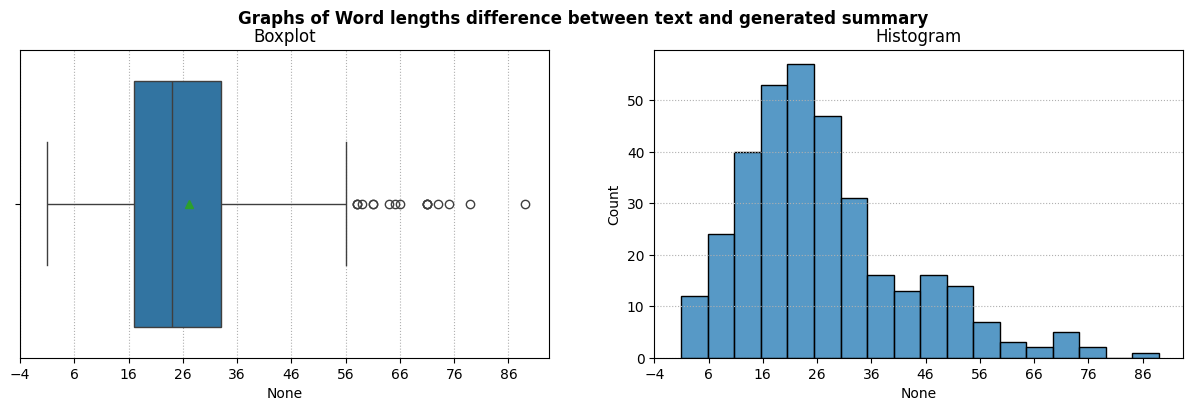

In [58]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle("Graphs of Word lengths difference between text and generated summary", fontweight="bold")

sns.boxplot(x=word_length_diff_ll, showmeans=True, ax=ax[0])
ax[0].grid(axis="x", linestyle="dotted", linewidth=0.8, alpha=1)
ax[0].set_xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
ax[0].set_title("Boxplot")

sns.histplot(x=word_length_diff_ll, binwidth=5, ax=ax[1])
ax[1].grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
ax[1].set_xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
ax[1].set_title("Histogram")

plt.show()

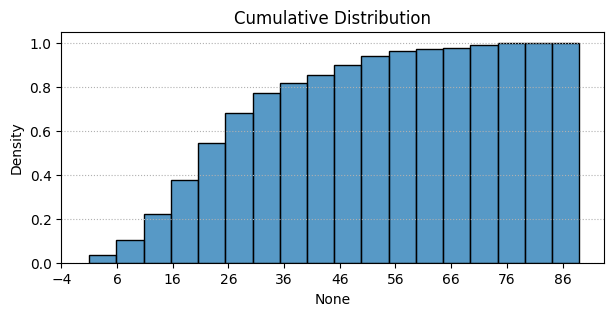

In [59]:
plt.figure(figsize=(7, 3))
plt.title("Cumulative Distribution")
sns.histplot(x=word_length_diff_ll, binwidth=5, kde=False, cumulative=True, stat="density")
plt.grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
plt.xticks( range( np.min(word_length_diff_ll)-5, np.max(word_length_diff_ll) + 5, 10) )
plt.show()

In [60]:
n1 = np.sum( np.array(word_length_diff_ll) <=0 )
n2 = len(word_length_diff_ll)
print("Total generated summaries with length greater than text: ", n1)
print("Total summaries: ", n2)
print("Ratio: ", n1/n2)

Total generated summaries with length greater than text:  0
Total summaries:  343
Ratio:  0.0


In [61]:
# display some of the generated summaries

total = 5

np.random.seed(5)
choice_list = np.random.choice(len(four_shot_summ_df), total, replace=False)

for i in choice_list:
    text = four_shot_summ_df.iloc[i]["text"]
    ref = four_shot_summ_df.iloc[i]["reference"]
    summ_gen = four_shot_summ_df.iloc[i]["summary_gen"]

    print("TEXT: ", text)
    print("REFERENCE: ", ref)
    print("SUMMARY GEN: ", summ_gen)
    print("\n")

TEXT:  The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided airspace disease.
REFERENCE:  No acute cardiopulmonary disease.
SUMMARY GEN:  Left lung granuloma persists, but left-sided airspace disease has resolved. 



TEXT:  Lordotic projection and large body habitus. Limited mediastinal evaluation. Severe cardiomegaly. No visualized pneumothorax. No large effusion or airspace disease. No fracture.
REFERENCE:  Severe cardiomegaly. Limited mediastinal evaluation given body habitus and lordotic projection. Recommend XXXX for further evaluation of mediastinum given T/Spine injury noted on C/Spine imaging. Critical result notification documented through Primordial.
SUMMARY GEN:  Severe cardiomegaly, lordotic projection, and large body habitus. 


Let me know


TEXT:  The heart and